## Theoretical Myopic and Hyperopic Defocus

Note that this section is not in Goodman and is just me deriving things.

In order to obtain a clear image at infinity, a photo-detector must be placed behind a lens at the distance where parallel incoming rays converge. By photo-detector we mean any image capturing device, such as a CCD, a film, or a bioligical retina. When the photo-detector is placed too close or too far, the image will start to become blurry. But how blurry exactly?

Since we want our results to generalize to the human eye, we also need to track index of refractions carefully. We use a simplified model as follows. Light starts in free space, passes through a lens with focal length $f$ and aperture diameter $d$, passes into a new material with index-of-refraction $n$, then travels a distance $z=L+\Delta L$ before hitting a photo-detector, where $L$ is the true convergence distance and $\Delta L$ is the error in photo-detector placement.

For a photo-detector placed at the convergence distance $L$, each angle of incoming light should theoretically converge to an infinitesimal point. However, the incorrect placement at $\Delta L$ causes light to spread out into a cone with angle $\alpha$ and vertical spread $\Delta y$. For small angles we have $\alpha = \Delta y / \Delta L$.

By ray-tracing the edges of this cone back through the convergence point $L$ towards the aperture edge $d$, we can also see that $\alpha = d/L$. Combining the two equations lets us elminate $\alpha$ and derive an expression for $\Delta y$:

$$\Delta y = d \frac{\Delta L}{L}$$

However, knowing the spread on a photo-detector in distance units isn't particularly useful, as intuitively the coordinates in an image have angular units. To convert this to an angular spread, we need to relate photo-detector positions to incoming ray angles.

Suppose we are at a height $y$ on the photo-detector. The angle of origination $\theta$ can be derived from a ray of light that passes through the free-space focal point, intersects a height $y$ on the lens, then travels straight towards the photo-detector. The index-of-refraction has no effect, since the ray is straight after passing through the lens. Since the lens inverts the image, we have the following relation:

$$\theta = -y/f$$

This relation implies the angular spread is given by:

$$\Delta \theta = -\frac{1}{f} \Delta y = -\frac{d}{f} \frac{\Delta L}{L}$$

This is useful as it relates errors in angular resolution to errors in axial length. However, an even more useful relation would with respect to errors in correction power. For instance, suppose we were curious what the world looked like with 0.25D of myopic blur. How would we calculate that?

Recall the definition of corrective power:

$$P = \frac{1}{f}$$

We need to write this in terms of $L$ in order to derive how errors in $\Delta L$ relate to errors in $\Delta P$. Therefore we need to derive a relation between $f$ and $L$.

Suppose an incoming straight ray intersects the lens at height $y$. Let $\theta_0$ be the angle it would have bent in free space, and $\theta$ be the true angle in the new medium. Assuming small angles we have:

$$\theta_0 = \frac{y}{f}, \theta = \frac{y}{L}$$

We can relate these two angles using Snells Law:

$$\theta_0 = n \theta$$

This implies:

$$\frac{y}{f} = n \frac{y}{L} \implies \frac{1}{f} = \frac{n}{L}$$

Therefore the relation between $P$ and $L$ becomes:

$$P = \frac{n}{L}$$

We can use this expression to relate errors in photo-detector distance to errors in corrective power. By taking the derivative and approximating with differentials we get the following:

$$\frac{dP}{dL} = -\frac{n}{L^2}$$

$$\Delta P = -\frac{n}{L} \frac{\Delta L}{L}$$

$$\frac{\Delta L}{L} = -\frac{L}{n} \Delta P = -f \Delta P$$

Substituting this into the expression for $\Delta \theta$ gives us a nice simplified expression:

$$\Delta \theta
= d \Delta P$$

According to Google the pupil size is anywhere from 2-8mm depending on lighting conditions. When converting this equation into arc-minutes we get around 3.4 arc-minutes per (mm diopter), so a quarter diopter of refractive error would result in around 1.7 - 6.9 arc-minutes of angular blur depending on lighting conditions. This seems about right, given the 20/20 line is 5 arc-minutes tall, and anecdotally people can read 20/20 with slight under-correction in bright lighting but not dim lighting.

# Simulating Myopic Defocus

The image below is an example of a Snellen Chart taken from the [Reduced Lens Wiki](https://wiki.reducedlens.org/wiki/Snellen_chart). The 20/20 line in this chart is 28 pixels tall and represents 5 arc-minutes of blur. Therefore we can use a 28/5 ratio when scaling arc-minutes into pixels to do a blur convolution. It's possible to do custom convolutions in python with [opencv](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html#d-convolution-image-filtering).

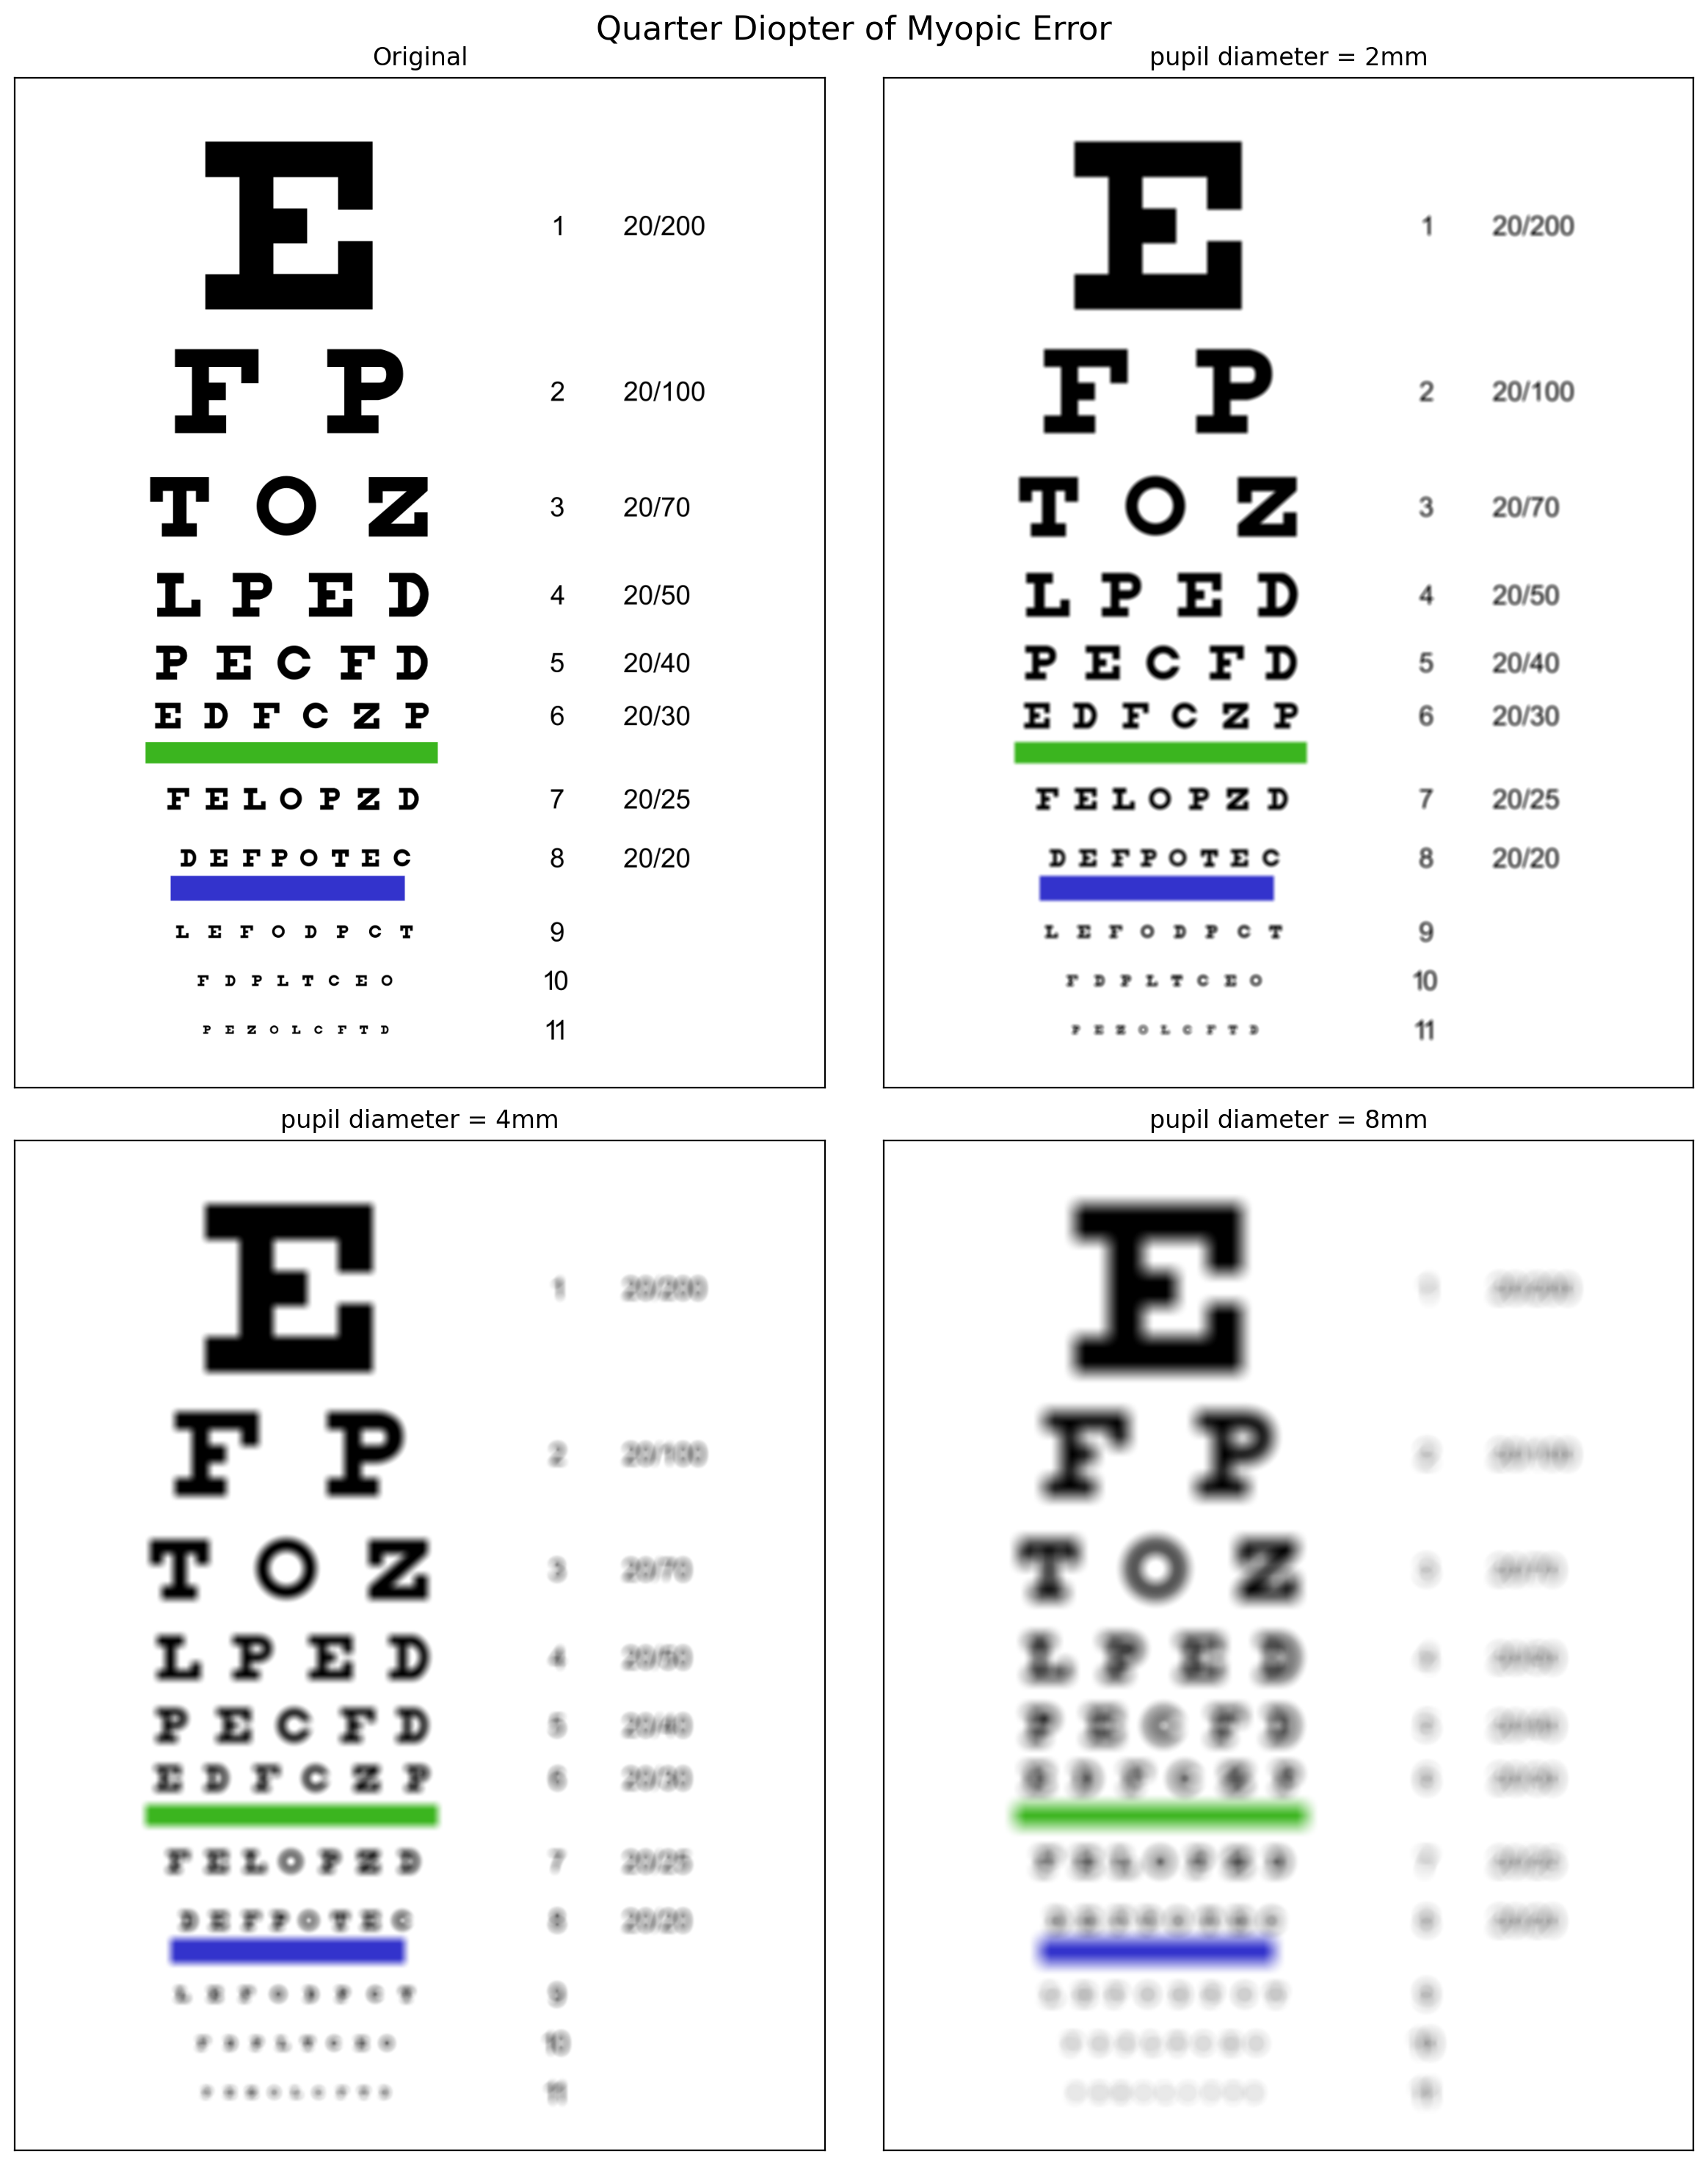

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('images/Snellen_chart.png')

pupils = [.002, .004, .008]
diopters = 0.25
rad2am = 360 / (2*np.pi) * 60
am2px = 28/5

plt.figure(figsize=(12,15), dpi=200)
plt.subplot(221),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])

for i,pupil in enumerate(pupils):
    d = int(pupil * diopters * rad2am * am2px)
    kernel = np.zeros((d,d),np.float32)
    delta = 2/(d-1)
    x,y = np.mgrid[-1:1+delta:delta, -1:1+delta:delta]
    kernel[(x**2+y**2<=1)] = 1
    kernel /= kernel.sum()
    dst = cv2.filter2D(img,-1,kernel)
    plt.subplot(220+i+2),plt.imshow(dst),plt.title(f'pupil diameter = {int(pupil*1000)}mm')
    plt.xticks([]), plt.yticks([])
plt.suptitle('Quarter Diopter of Myopic Error', fontsize=16)
plt.tight_layout()
plt.savefig('images/myopic_defocus.png')
plt.show()

# Pure Astigmatic Defocus

The geometric argument above is the same for astigmatism, in which we assume only a single directional axis has error $\Delta \theta$ while the perpendicular axis is in focus. We can simulate astigmatic refractive error by placing a convex cylindrical lens behind a correctly focusing lens. Note the aperture is still a circle, even though the extra lens bends light cylindrically. 

If the cylinder applies correction along an axis $\phi$, note that the all points on the perpendicular axis $\phi+\pi/2$ which pass through the middle of the cylindrical lens still focus correctly. This means the convolution, while line-segment shaped, does not have equal weighting throughout the line. Rather, weights along the line segment are proportional to the chord length of the perpendicular axis $\sqrt{r^2-h^2}$. Note this is different to the myopic case, where every point on the circle had the same weight.

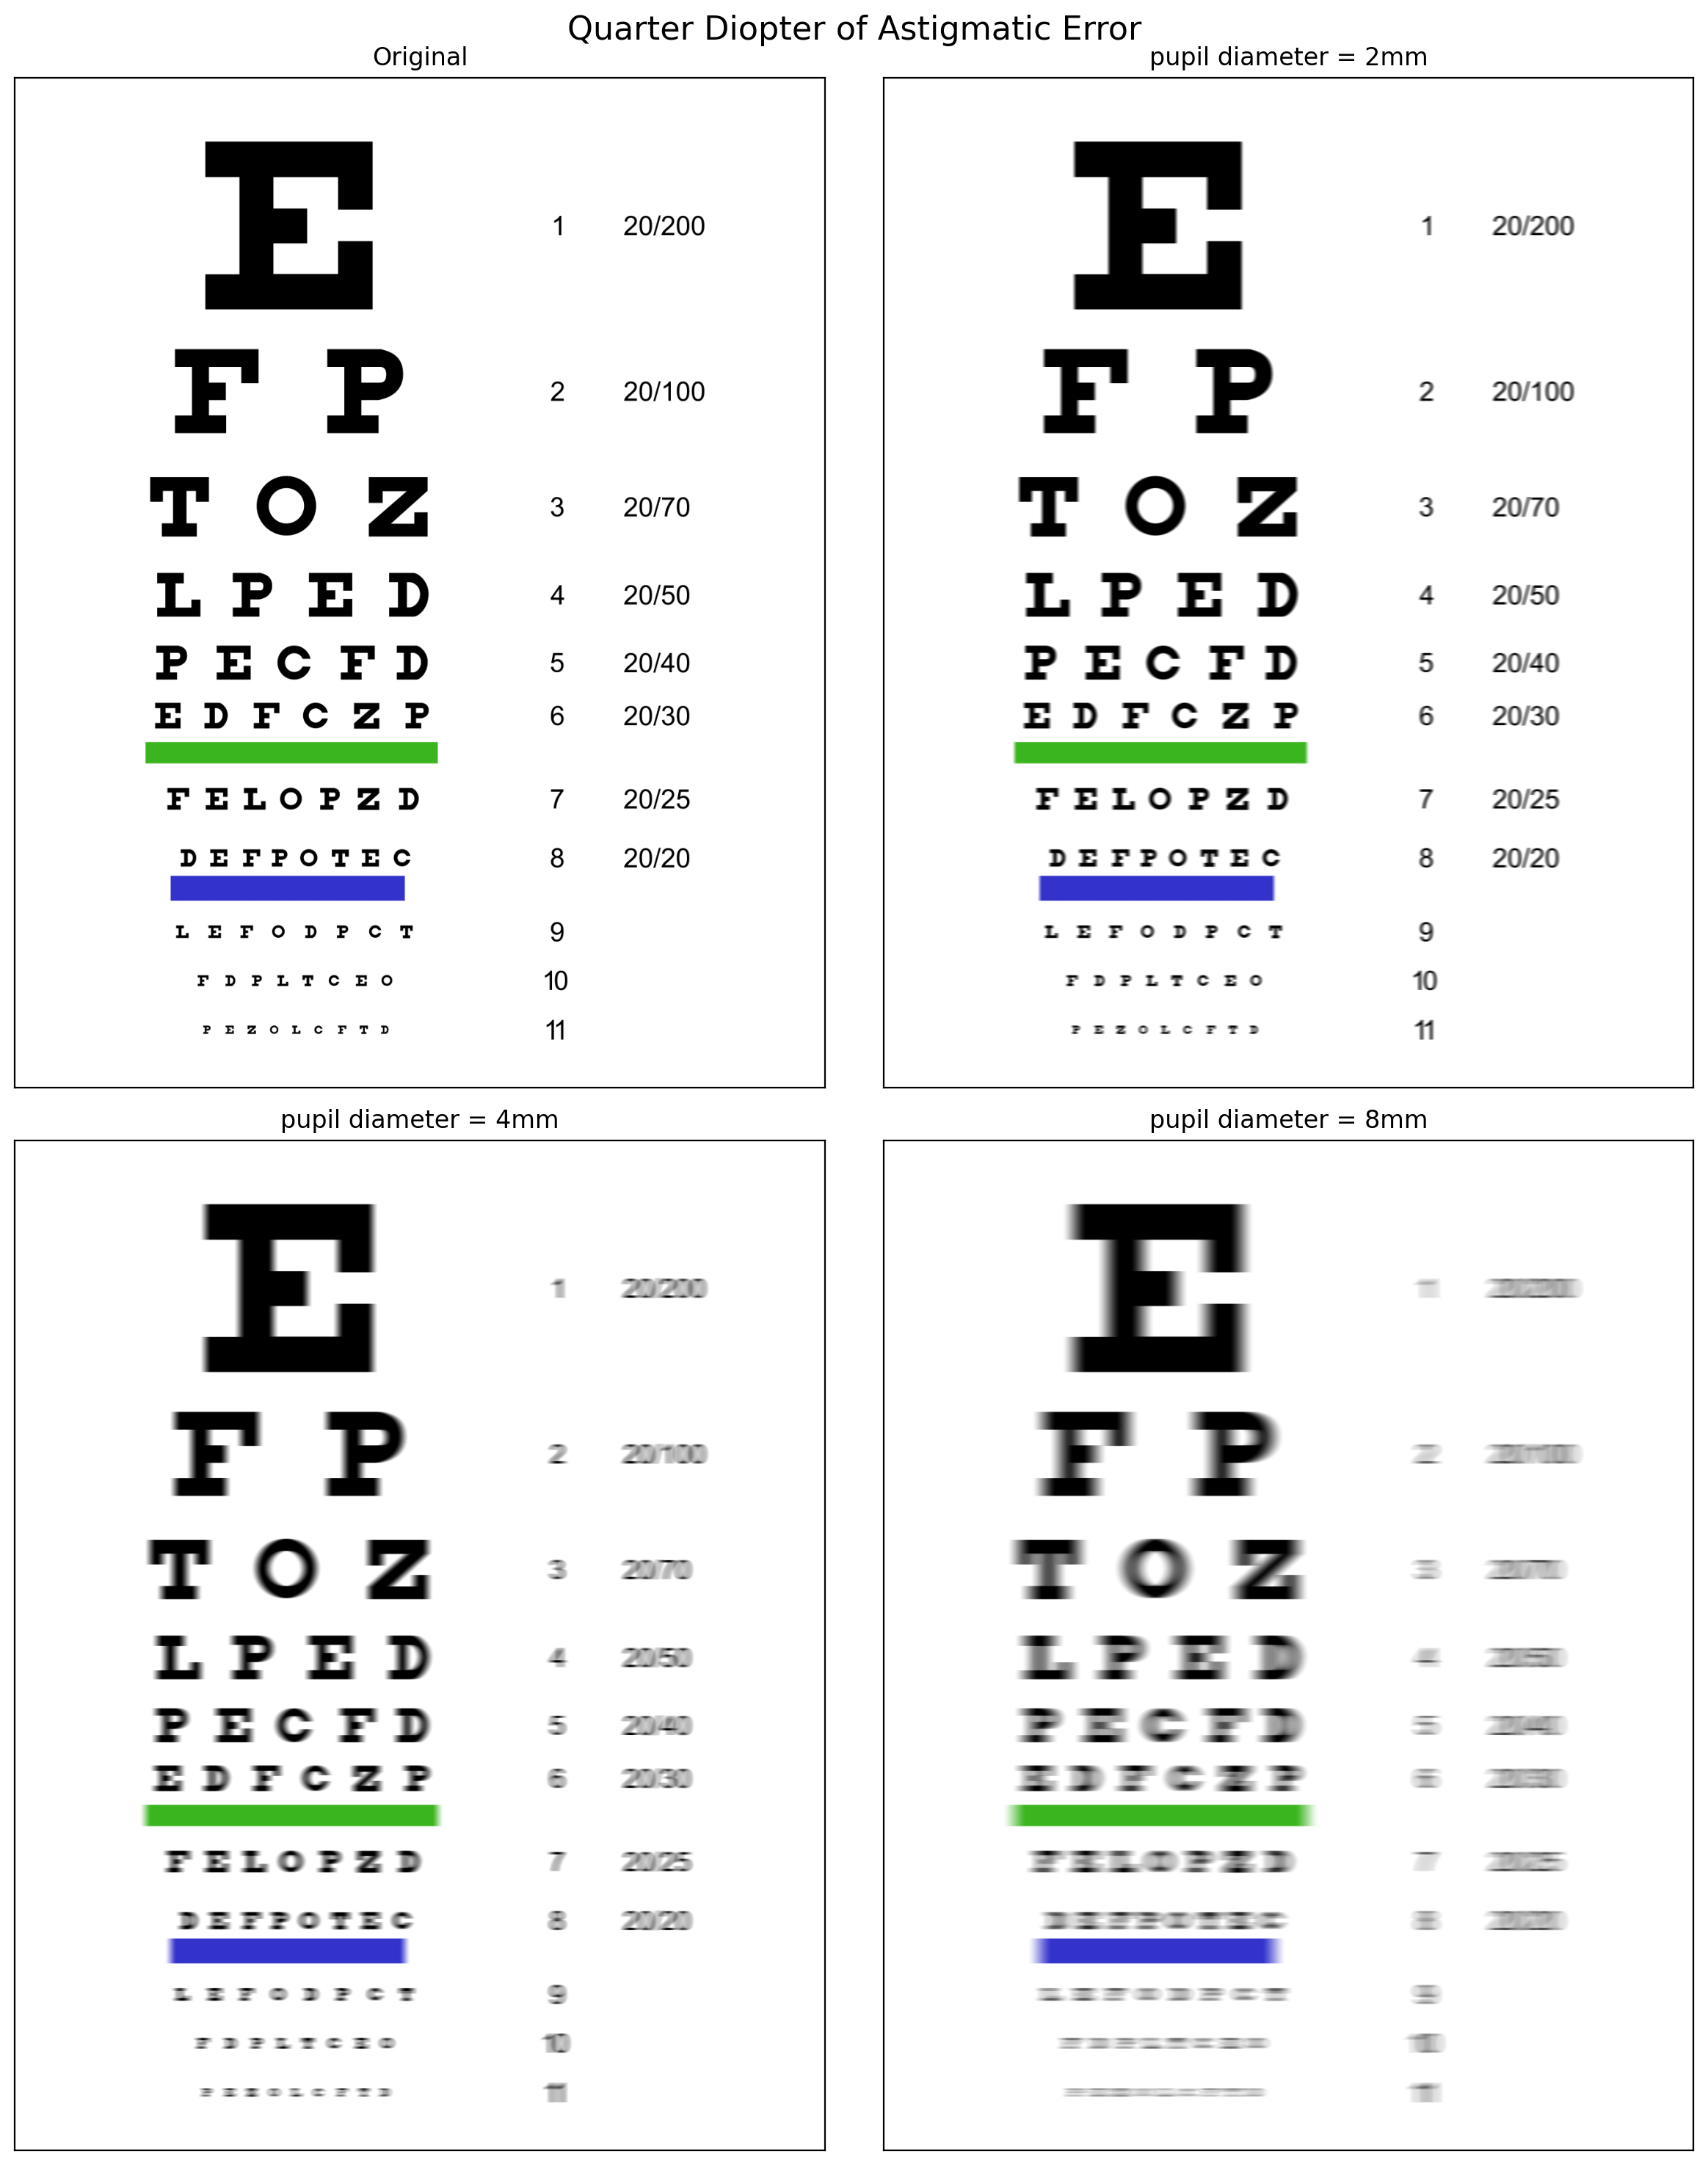

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter

img = cv2.imread('images/Snellen_chart.png')

pupils = [.002, .004, .008]
diopters = 0.25
rad2am = 360 / (2*np.pi) * 60
am2px = 28/5

plt.figure(figsize=(12,15), dpi=200)
plt.subplot(221),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])

for i,pupil in enumerate(pupils):
    d = int(pupil * diopters * rad2am * am2px/2)*2+1 # make it an odd number
    center = int((d-1)/2)
    kernel = np.zeros((d,d),np.float32)
    
    delta = 2/(d-1)
    x,y = np.mgrid[-1:1+delta:delta, -1:1+delta:delta]

    # horizontal
    kernel[center,:] = 1
    weight = np.sqrt(1-y**2)
    
    # vertical
    # kernel[:,center] = 1
    # weight = np.sqrt(1-x**2)

    # diagonal
    # kernel[x==-y] = 1
    # kernel[(x**2+y**2)>=1] = 0
    # weight = np.sqrt(np.abs(1-x**2-y**2))

    kernel *= weight
    kernel /= kernel.sum()
    dst = cv2.filter2D(img,-1,kernel)
    plt.subplot(220+i+2),plt.imshow(dst),plt.title(f'pupil diameter = {int(pupil*1000)}mm')
    plt.xticks([]), plt.yticks([])
plt.suptitle('Quarter Diopter of Astigmatic Error', fontsize=16)
plt.tight_layout()
plt.savefig('images/astigmatic_defocus.png')
plt.show()

# Combining Sph and Cyl

One way to combine arbitrary sph and cyl is to solve the problem numerically. The strategy is to divide the aperture into an NxN grid and calculate the aberration $\Delta \theta_x$ and $\Delta \theta_y$ for each point on the aperture $r<d/2$, then compute the 2D histogram of all these aberrations in pixel units. This 2D histogram is the blur kernel, as it provides a weighted count of how many pixels to blur each point in each direction.

Some interesting cases include pure cyl at off-angles, combined cyl+sph, and opposing cyl+sph. If cyl and sph are opposed and of equal magnitude, the net effect is to rotate the cyl axis by 90 degrees and flip its sign. If cyl and sph are opposed and of equal spherical equivalent (cyl=2*sph), the net effect is a round blur, but composed of a myopic direction and hyperopic direction. Since this notebook assumes no chromatic abberation, myopic and hyperopic blur are indistinguishable, but an actual eye could potentially distinguish these using LCA (Longitudinal Chromatic Aberration).

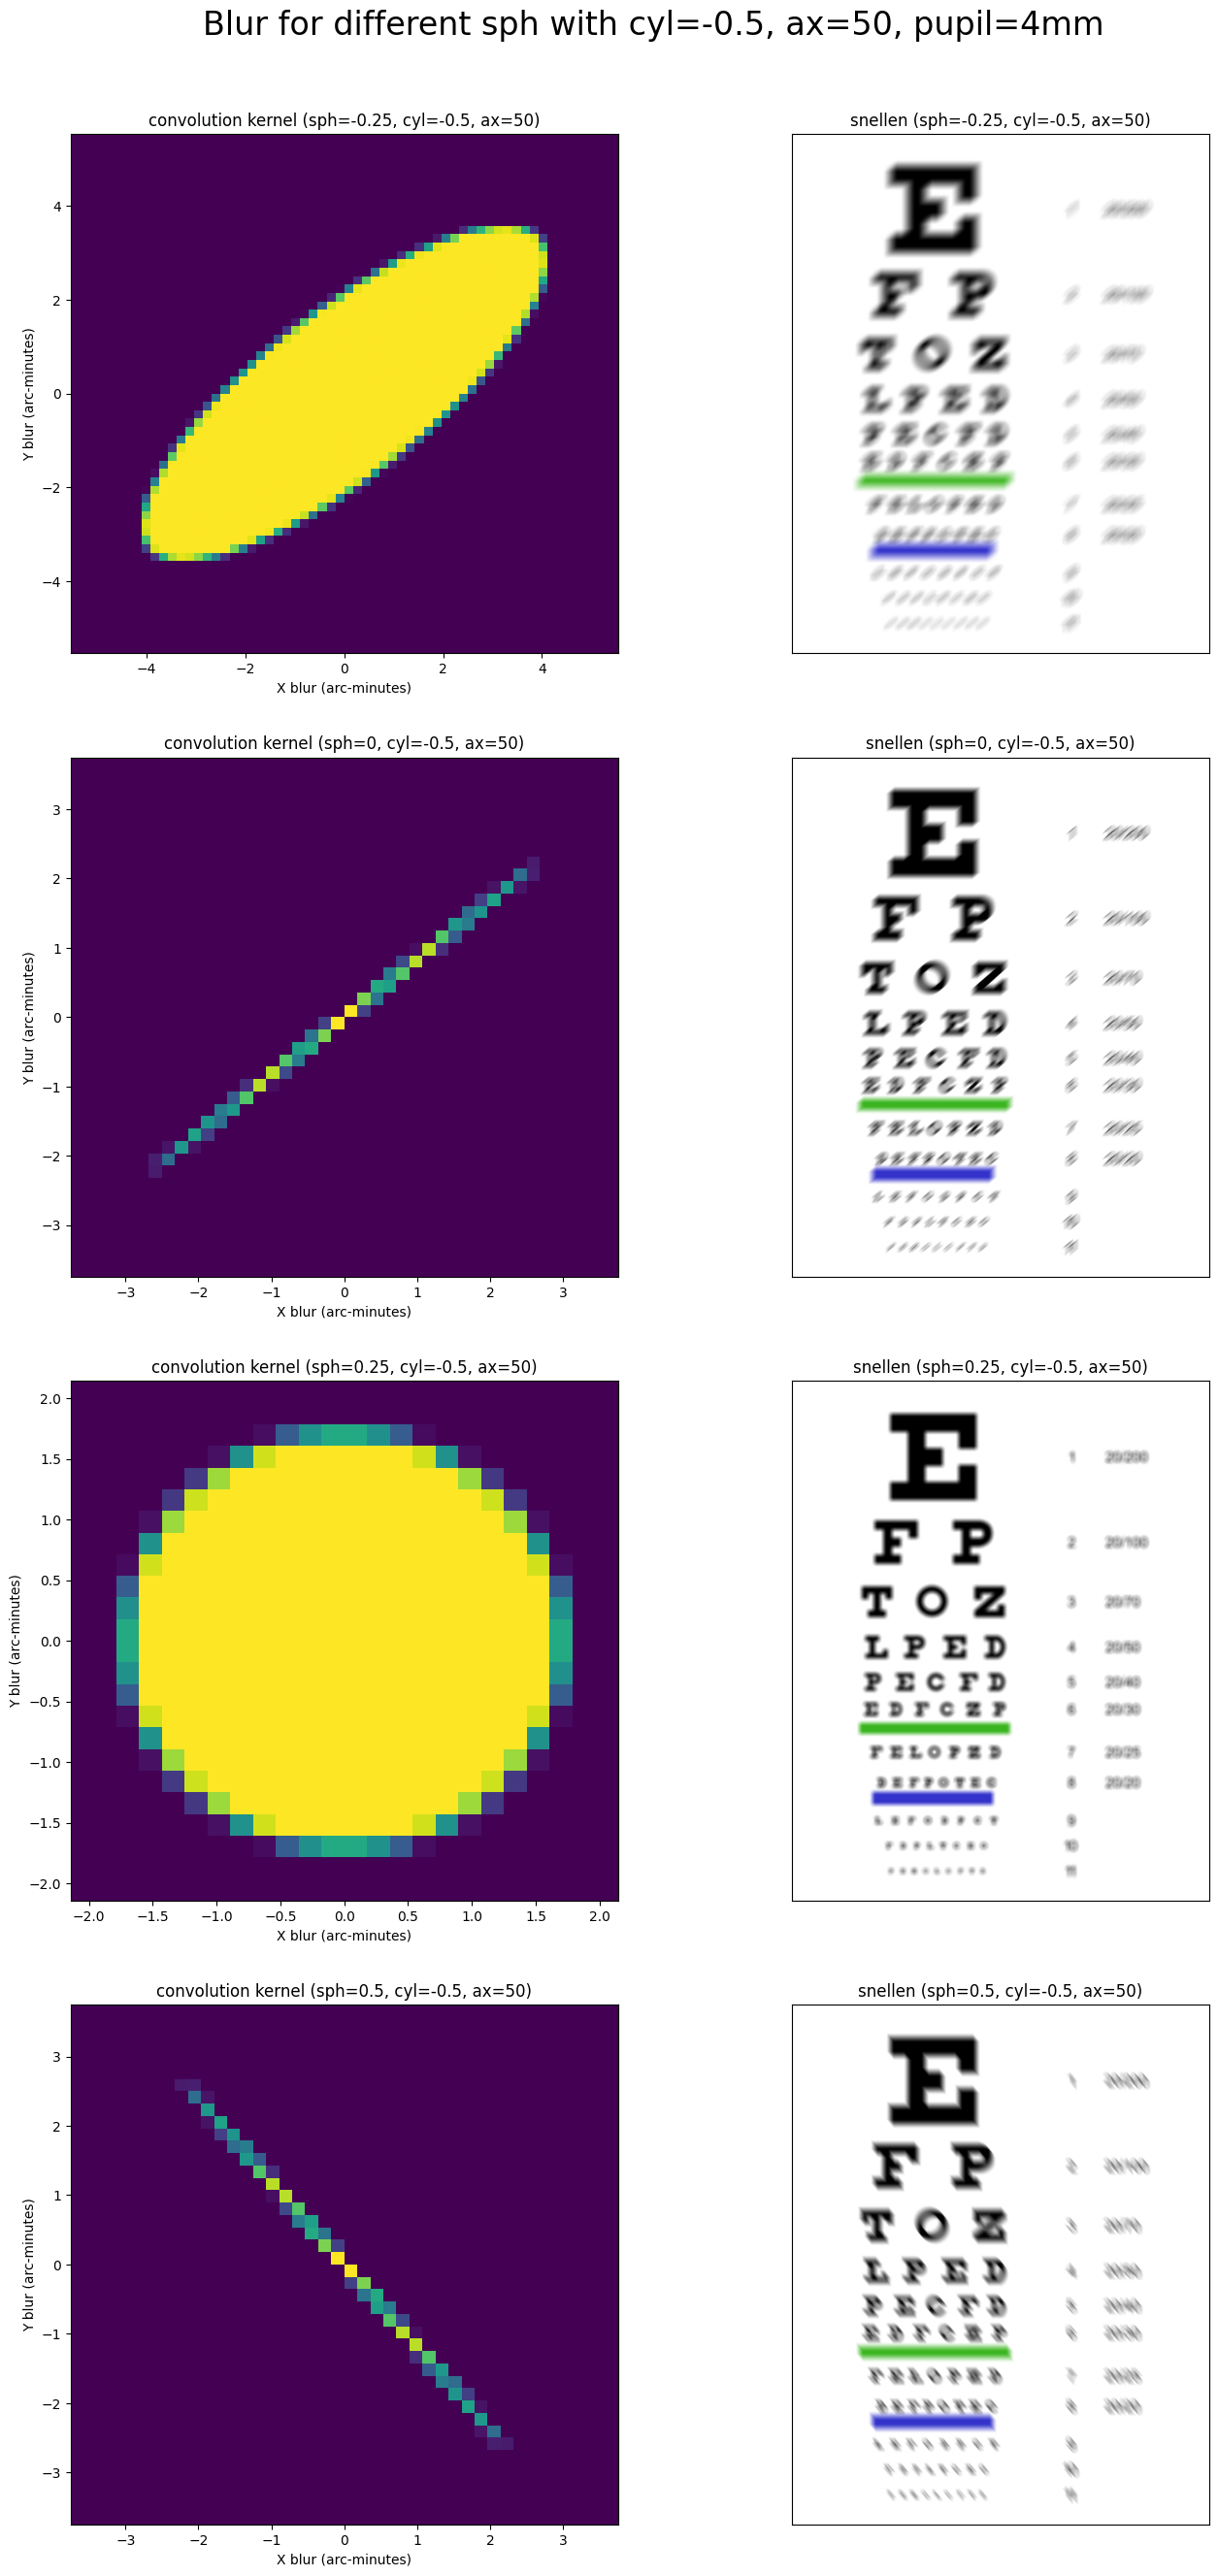

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 2, figsize=(16, 32))

d = .004 # pupil diameter
N = 1001

rad2am = 360 / (2*np.pi) * 60
am2px = 28/5
epsilon = 1e-8

img = cv2.imread('images/Snellen_chart.png')

def plot(sph_err, cyl_err, cyl_ax_deg, ax_kernel, ax_snellen):
    cyl_ax = cyl_ax_deg * (2*np.pi/360)
    
    # input number is the axis of rotation of the cylindrical lens
    # blur direction is 90 degree offset
    # minus sign comes from flipping doctor's perspective to patient's perspective
    blur_angle = np.pi/2 - cyl_ax
    
    r = d/2
    dx = d/(N-1)
    x,y = np.mgrid[-r:r:dx, -r:r:dx]

    aperture = np.zeros((N,N), dtype=int)
    aperture[np.sqrt(x**2+y**2)<=r] = 1
    
    # sph
    ab_x_sph = x * sph_err * rad2am * am2px
    ab_y_sph = y * sph_err * rad2am * am2px
    
    # cyl
    phi = np.arctan2(y,x)
    dist = np.sqrt(x**2+y**2) * np.cos(phi-blur_angle)
    ab_x_cyl = dist*np.cos(blur_angle) * cyl_err * rad2am * am2px
    ab_y_cyl = dist*np.sin(blur_angle) * cyl_err * rad2am * am2px

    # epsilon helps provide straight lines in cases of 0 or 90 which introduce asymmetrical ~1e-16 errors
    ab_x = ab_x_sph + ab_x_cyl + epsilon
    ab_y = ab_y_sph + ab_y_cyl + epsilon
    
    max_x = np.ceil(np.abs(ab_x)).max()
    max_y = np.ceil(np.abs(ab_y)).max()
    max_px = int(max(max_x, max_y))
    bins = (np.linspace(-max_px, max_px, max_px*2+1), np.linspace(-max_px, max_px, max_px*2+1))
    
    ab, x_edges, y_edges = np.histogram2d(ab_x.flatten()[aperture.flatten()==1], ab_y.flatten()[aperture.flatten()==1], bins=bins)

    # convert to cartesian
    # see https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html
    ab = ab.T

    x_edges_am = x_edges / am2px
    y_edges_am = y_edges / am2px
    ax_kernel.pcolormesh(x_edges_am, y_edges_am, ab)
    ax_kernel.set_title(f'convolution kernel (sph={sph_err}, cyl={cyl_err}, ax={cyl_ax_deg})')
    ax_kernel.set_xlabel('X blur (arc-minutes)')
    ax_kernel.set_ylabel('Y blur (arc-minutes)')
    
    kernel = ab / ab.sum()
    dst = cv2.filter2D(img,-1,kernel[:, ::-1])
    ax_snellen.imshow(dst)
    ax_snellen.set_title(f'snellen (sph={sph_err}, cyl={cyl_err}, ax={cyl_ax_deg})')
    ax_snellen.set_xticks([])
    ax_snellen.set_yticks([])

sph_errs = [-0.25, 0, 0.25, 0.5]
cyl_errs = [-0.5, -0.5, -0.5, -0.5]
cyl_ax_deg = 50

for i, (sph_err, cyl_err) in enumerate(zip(sph_errs, cyl_errs)):
    plot(sph_err, cyl_err, cyl_ax_deg, axs[i,0], axs[i,1])

plt.suptitle('Blur for different sph with cyl=-0.5, ax=50, pupil=4mm', y=0.92, fontsize=24)
plt.savefig('images/combined_sph_cyl_defocus.png')
plt.show()